Remember to `pip install numpy scipy scikit-learn pandas matplotlib quandl` before proceeding

In [1]:
import math
import numpy as np
import pandas as pd
import quandl

from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression

## Some info about the libraries:
- **numpy** is used to convert data into numpy arrays
- **pandas** is used for dataframes
- **quandl** is used to get the dataset
- **preprocessing**is the module used to do some cleaning/scaling of data prior to machine learning
- **svm** and **LinearRegression** are the machine learning algorithms we use to demonstrate results

Lets get a dataset from quandl. (Below dataset contains details about Google stock prices from August-19-2014 to March-27-2018)

In [5]:
df = quandl.get("WIKI/GOOGL", auth_token="1pt6AV6M_Qt5_y3o4AmH")

**NOTE:** Register for Quandl (its free!) and insert your API key if you get an error saying *"Limit Exceeded"*

In [7]:
# df.head()

We don't need all the columns for our training. Lets keep only the columns we need.

In [8]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
# df.head()

## Selecting features
This is the point we have to think *'what features shall we choose for our model?'*. Now we have to think based on the available data and what we have to predict.  
So with respect to stock prices:
- Historical prices aren't that indicative of future prices
- Historical patterns has a bit more merit when taken to the extremes, but is overall fairly weak
- Relationship between price changes and volume over time, along with historical patterns is probably a bit better
- Daily percent change is also a good feature  

So the three features we are selecting:
1. Current price
2. High minus low percent, and 
3. The percent change 

So lets transform the data we need.

In [9]:
# calculating volatility
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / (df['Adj. Low']) * 100.0

# calculating daily % change
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

# lets create dataframe with new features
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

In [10]:
# df.head()

## Selecting label
- Here, we want to predict the stock price. 
- For training and testing we need to add a label for our dataset.  
- Assume that we want to predict the **Adj. Close** price for around 1% of our dataset (which comes around 35 days) ahead from current date.  
- So with the existing dataset, we create a new column for our label and fill it with values of **Adj. Close** but shifted 35 rows above.  
- This means for each row the features are **current price, high minus low percent, and the percent change volatility** whereas label is **Adj. Close** 35 days in future. 

In [11]:
# replacing NaN or None values with some large negative value
# with many machine learning classifiers, this value will just be recognized and treated as an outlier feature
# You can also just drop all feature/label sets that contain missing data, but then you're leaving a lot of data out.
df.fillna(value=-99999, inplace=True)

predict_col = 'Adj. Close'
predict_out = math.ceil(0.01 * len(df))
df['label'] = df[predict_col].shift(-predict_out)    # negative means shift upwards in terms of rows

In [12]:
# lets see our dataframe now
# df.tail()

Notice above that last few values (35 to be exact) of **label** are NaN. That is expected as we had shifted the values for **label** by 35 and we don't have predictions for last 35 rows.  
What we can do is, we can use that for prediction in future.

It is a typical standard with machine learning in code to define **X** (capital x), as the **features**, and **y** (lowercase y) as the **label** that corresponds to the features.

In [13]:
X = np.array(df.drop(['label'],1))

df.dropna(inplace=True)
y = np.array(df['label'])

After executing the above block of code, **X** has features (including the last 34 rows which doesn't have labels) and,  
**y** has labels (without the NaN values - we simply dropped them from dataframe)

## Preprocessing
Generally, we want our features in machine learning to be in a range of -1 to 1. This may do nothing, but it usually speeds up processing and can also help with accuracy. Because this range is so popularly used, it is included in the preprocessing module of Scikit-Learn.

In [14]:
# apply preprocessing.scale to our X variable
X = preprocessing.scale(X)

Lets seperate out the last few rows (34 rows which has NaN values as labels) from training set and we'll use it in future for prediction.  

In [15]:
X_lately = X[-predict_out:]
X = X[:-predict_out]

Why are we separating the data after scaling? We could've done it before itself right? - No. Reason below:
- We decided that we're forecasting/predicting out 1% of the data, thus we will want to generate forecasts for each of the final 1% of the dataset.  
- Consider the data we're trying to forecast is not scaled like the training data was. Now, do we just do preprocessing.scale() against the last 1%? **The scale method scales based on all of the known data that is fed into it.** So ideally, you would scale both the training, testing, **AND** forecast/predicting data all together.  
- Is this always possible or reasonable? - No. If you can do it, you should, however. In our case, right now, we can do it. Our data is small enough and the processing time is low enough, so we'll preprocess and scale the data all at once.

## Spitting Dataset
- Lets take 75% of data, and use this to train the machine learning classifier. 
- Then lets take the remaining 25% of the data, and test the classifier. Through testing, we can get a sort of accuracy and reliability, often called the confidence score.  

There are many ways to split the dataset. Probably the best way is to use the built-in **model_selection**, since this also shuffles the data for us. 

In [16]:
# good practice to ensure dimesions of both the features array and label array before proceeding
print(len(X), len(y))

3389 3389


In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

## Training
Now, we're ready to define our classifier and train it. 
There are many classifiers available through scikit-learn, and even a few specifically for regression. 
Let's use **LinearRegression** from Scikit-Learn's linearmodel package.  
Using a different algorithm is just a single line change, thanks to scikit-learn.  
(You can learn more about Linear Regression <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">here</a> and SVM <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html">here</a>)

In [18]:
clf = LinearRegression() 
# clf = svm.SVR()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

In [19]:
confidence

0.9788271075779186

Creating a linear model with say >95% accuracy is not that great. There are still many issues to consider.  

## Pickling
While our machine learning classifier takes a few seconds to train, there may be cases where it takes hours or even days to train a classifier. Imagine needing to do that every day you wanted to forecast prices, or whatever. This is not necessary, as we can just save the classifier using the Pickle module. 

In [20]:
import pickle

with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)

In [21]:
# now we can simply load the classifier from the pickle file
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

## Prediction

In [22]:
predict_set = clf.predict(X_lately)

In [23]:
# print(f"Prediction Set: {predict_set}")
print(f"Confidence: {confidence}")
print(f"Number of Predictions: {predict_out}")

Confidence: 0.9788271075779186
Number of Predictions: 35


## Visualizing data

In [24]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

Now, we're going to add a new predict column to our dataframe and fill it with NaN at first. We'll populate the data later.

In [25]:
df['Predict'] = np.nan

To begin predicting for, say 35 days in future, we need to first grab the last day in the dataframe, and begin assigning each new prediction to a new day. 

In [26]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400 - 19800
next_unix = last_unix + one_day

Now we have the next day we wish to use, and one_day is 86,400 seconds (subtracting timezone difference of 19,800 for GMT which is 5hr 30min). Now we add the forecast to the existing dataframe. 

In [27]:
for i in predict_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

- All we're doing above is iterating through the prediction set, taking each prediction and day, and then setting those values in the dataframe (making the future "features" NaNs).  
- The last line in the above `for` loop just simply takes all of the first columns (which contains features), setting them to NaNs (since we don't know the features yet for the future dates), and then the final column is whatever `i` is (the prediction in this case).  
- This one-liner for loop is a cool hack, so that the code can still work even if we decide to change up the dataframe and features.

In [28]:
# df.tail(50)

Just one last minor thing to do before plotting.  
We will plot the *'Adj. Close'* of actual data first and then follow with our *prediction label* in the same graph.  
For the graph to be continous, there should be one day overlap of prediction column.  
(This can be ignored if you are okay with seeing a one day blip in the graph).

In [29]:
last_row_before_forecast = df.loc[last_date]
df.loc[last_date] = np.hstack((last_row_before_forecast.values[:-1], last_row_before_forecast[predict_col]))

Lets plot the graph!

<IPython.core.display.Javascript object>


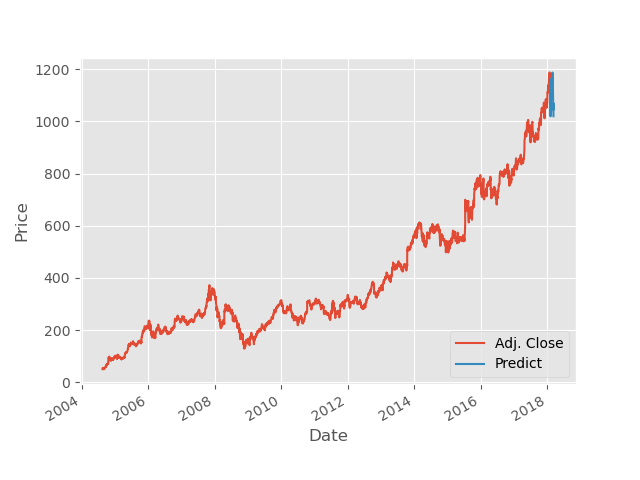

In [30]:
%matplotlib notebook
df['Adj. Close'].plot()
df['Predict'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()